# Overview

In 2021, An image is Worth 16x16 $Words^2$ suceesfully adapted transformers for computer vision tasks. Let's walks through the Vision Transformer(ViT) as laid out in An Image is Worth 16x16 $Words^2$. The ViT only uses an encoder, and the output of the encoder is then passed to a neural network "head" that makes a prediction. In this notebook, we will try to visulize the postion embeddings.

F=60 and W=100 pixels.


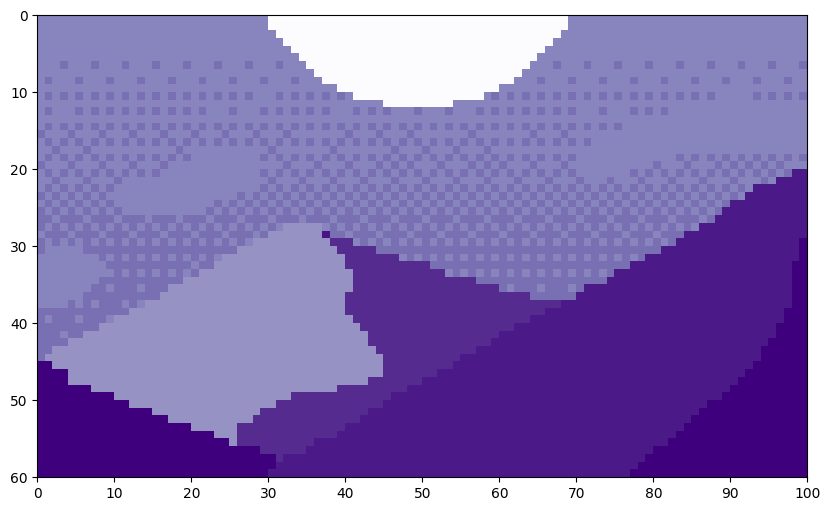

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt


img=os.path.join('/kaggle/input/cropped-and-single-channel-image/mountains.npy')

mountains=np.load(img)

def plt_generator():
    fig=plt.figure(figsize=(10,6))
    # We will be displaying it in a purple color scheme because its easier to see
    plt.imshow(mountains, cmap='Purples_r')
    return plt

H=mountains.shape[0]
W=mountains.shape[1]
print(f'F={H} and W={W} pixels.')

plt=plt_generator()
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax=fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0,1])
plt.colorbar(cax=cbar_ax)

# Split Image

WE split image up into patches of size 20.

There will be 15 patches, each 20 by 20


Text(49.5, 9.5, '3')

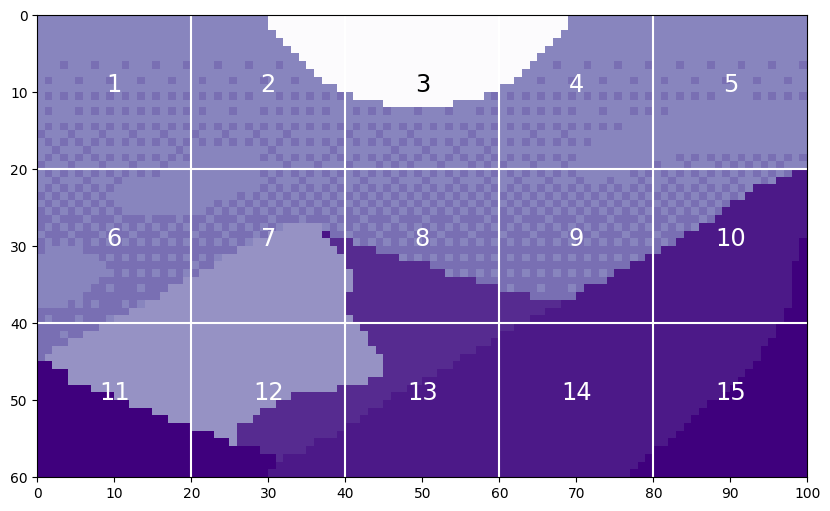

In [25]:
P=20
N=int((H*W)/(P**2))
print(f'There will be {N} patches, each {P} by {P}')

plt=plt_generator()
plt.clim([0,1])
plt.hlines(np.arange(P,H,P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P,W,P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text=np.tile(np.arange(9.5, W, P), 3)
y_text=np.repeat(np.arange(9.5, H, P),5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center')

The caim is that viesion transformers would be unable to distinguish the original image with a version where the patches had been scrambled. Obviously, below is a very different image from the original.

Text(29.5, 29.5, '3')

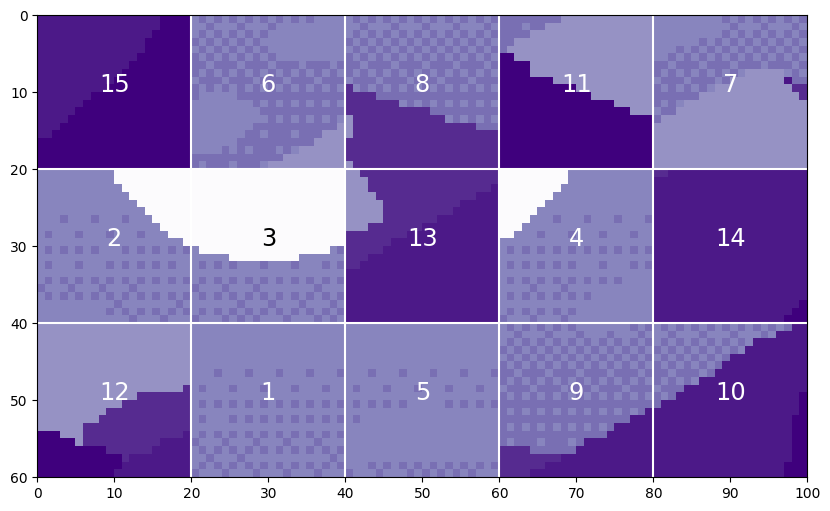

In [30]:
np.random.seed(21)
scramble_order = np.random.permutation(N)
left_x = np.tile(np.arange(0, W-P+1, 20), 3)
right_x = np.tile(np.arange(P, W+1, 20), 3)
top_y = np.repeat(np.arange(0, H-P+1, 20), 5)
bottom_y = np.repeat(np.arange(P, H+1, 20), 5)

scramble = np.zeros_like(mountains)
for i in range(N):
    t = scramble_order[i]
    scramble[top_y[i]:bottom_y[i], left_x[i]:right_x[i]] = mountains[top_y[t]:bottom_y[t], left_x[t]:right_x[t]]
    
fig = plt.figure(figsize=(10,6))
plt.imshow(scramble, cmap='Purples_r')
plt.clim([0,1])
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w')
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
x_text = np.tile(np.arange(9.5, W, P), 3)
y_text = np.repeat(np.arange(9.5, H, P), 5)
for i in range(N):
    plt.text(x_text[i], y_text[i], str(scramble_order[i]+1), color='w', fontsize='xx-large', ha='center')
    
i3 = np.where(scramble_order==2)[0][0]
plt.text(x_text[i3], y_text[i3], str(scramble_order[i3]+1), color='k', fontsize='xx-large', ha='center')

# Attention Invariance Up to Permutation

The component of the transformer that would be invariant to token order is the attention module. Attention is computed from three matrices Q,K and V each generated from passing the tokens through a linear layer. Once the Q, K and V matrices are genrated, attention is computed using the following formula:

$$Attention(Q, K,V)=softmax(\frac{Q*K^T}{\sqrt{d_k}})*V$$

$d_k$ is a scaling value. The shape of Q, K and V is as follows:

![](https://cdn.masto.host/sigmoidsocial/media_attachments/files/112/035/665/366/068/439/original/7808a26cf399d3d8.png)

We will use 4 tokens of projected length 9 in this example. The matrices will contain integers to avoid floating point multiplication errors. Once generated, we will switch the position of token 0 and in all three matrices. Matrices with swapped tokens will be denoted will a subscripts 's'.

y is 4 and x is 9
y is 4 and x is 9
y is 4 and x is 9
y is 4 and x is 9
y is 4 and x is 9
y is 4 and x is 9


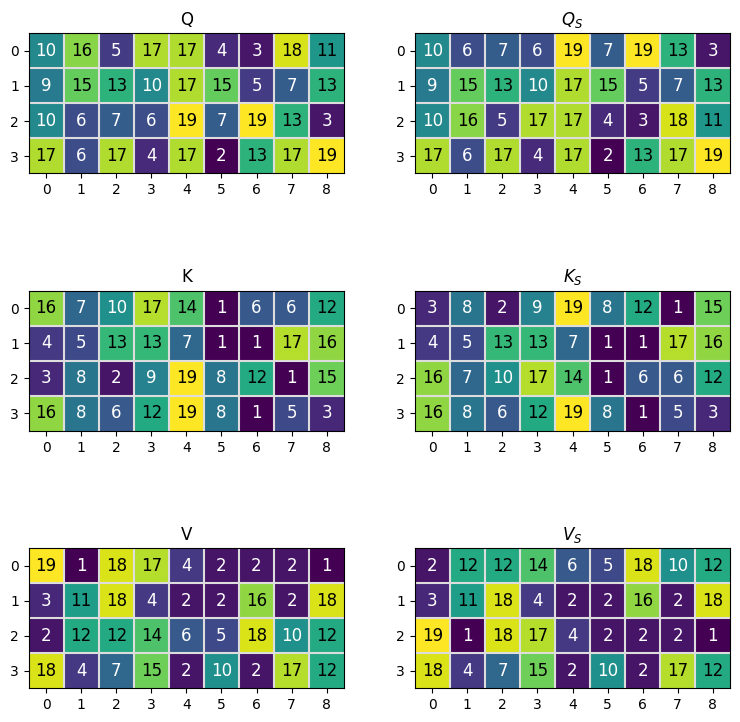

In [33]:
import copy

def mat_plot(matrix, title):
    up_clim=max(np.abs(matrix.flatten()))
    low_clim=min(np.abs(matrix.flatten()))
    y,x=matrix.shape
    print(f'y is {y} and x is {x}')
    
    im=plt.imshow(matrix, cmap='viridis')
    plt.xticks(ticks=np.arange(x));
    plt.yticks(ticks=np.arange(y));
    plt.title(title)
    plt.vlines(np.arange(0.5, x-0.5, 1), -0.5, y-0.5, colors='#DDDDDD')
    plt.hlines(np.arange(0.5, y-0.5, 1), -0.5, x-0.5, colors='#DDDDDD')
    
    ## Adding Value Labels
    for i in range(y):
        for j in range(x):
            if matrix[i,j]==0:
                pass
            elif np.abs(matrix[i,j])>low_clim+((up_clim-low_clim)/2):
                plt.text(j,i,round(matrix[i,j],2), ha='center', va='center', color='k', fontsize=12)
            else:
                plt.text(j,i, round(matrix[i,j],2), ha='center', va='center', color='w', fontsize=12)
                
n_tokens=4
l_tokens=9
shape=n_tokens, l_tokens
mx=20 # integer for generated matrices

# Generate Normal Matrices
np.random.seed(21)
Q=np.random.randint(1, mx, shape)
K=np.random.randint(1, mx, shape)
V=np.random.randint(1, mx, shape)

# Generate Row-Swapped Matricies
swapQ=copy.deepcopy(Q)
swapQ[[0,2]]=swapQ[[2,0]]
swapK=copy.deepcopy(K)
swapK[[0,2]]=swapK[[2,0]]
swapV=copy.deepcopy(V)
swapV[[0,2]]=swapV[[2,0]]

# Plot Matrices
fig,axs=plt.subplots(nrows=3, ncols=2, figsize=(8,8))
fig.tight_layout(pad=2.0)
plt.subplot(3,2,1)
mat_plot(Q, 'Q')
plt.subplot(3,2,2)
mat_plot(swapQ, r'$Q_S$')

plt.subplot(3,2,3)
mat_plot(K, 'K')
plt.subplot(3,2,4)
mat_plot(swapK, r'$K_S$')

plt.subplot(3,2,5)
mat_plot(V, 'V')
plt.subplot(3,2,6)
mat_plot(swapV, r'$V_S$')

The first matrix multiplication in the attention formula is $Q*K^T=A$, where the resulting matrix A is a square with size equal to the number of tokens. When we compute $A_s$ with $Q_s$ and $K_s^T$, the resulting $A_s$ has both rows [0,2] swapped from A.

modA:[[1111 1014  895 1003]
 [ 875  667  849  832]]
Swaped modA [[ 875  667  849  832]
 [1111 1014  895 1003]]
----------
y is 4 and x is 4
y is 4 and x is 4
y is 4 and x is 4


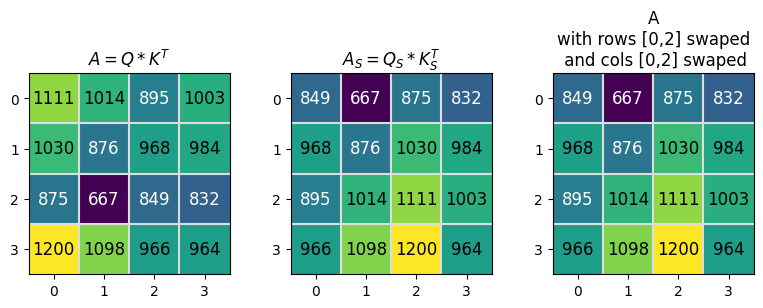

In [39]:
A=Q@K.transpose()
swapA=swapQ@swapK.transpose()
modA=copy.deepcopy(A)
print(f'modA:{modA[[0,2]]}')
modA[[0,2]]=modA[[2,0]] # swap rows
print(f'Swaped modA {modA[[0,2]]}')
modA[:, [2,0]]=modA[:,[0,2]] #swap cols

print(20*'-')
fig,axs=plt.subplots(nrows=1, ncols=3, figsize=(8,3))
fig.tight_layout(pad=1.0)
plt.subplot(1,3,1)
mat_plot(A, r'$A=Q*K^T$')
plt.subplot(1,3,2)
mat_plot(swapA, r'$A_S=Q_S*K_S^T$')
plt.subplot(1,3,3)
mat_plot(modA, 'A\nwith rows [0,2] swaped\n and cols [0,2] swaped')

The next matrix multiplications is $A*V=A$, where the resulting matrix A has the same shape as the initial Q, K and V matrices. When we compute $A_s$ with $A_s$ and $V_s$ the resulting $A_s$ has rows [0,2] swapped from A.

y is 4 and x is 9
y is 4 and x is 9
y is 4 and x is 9


(0.0, 1.0, 0.0, 1.0)

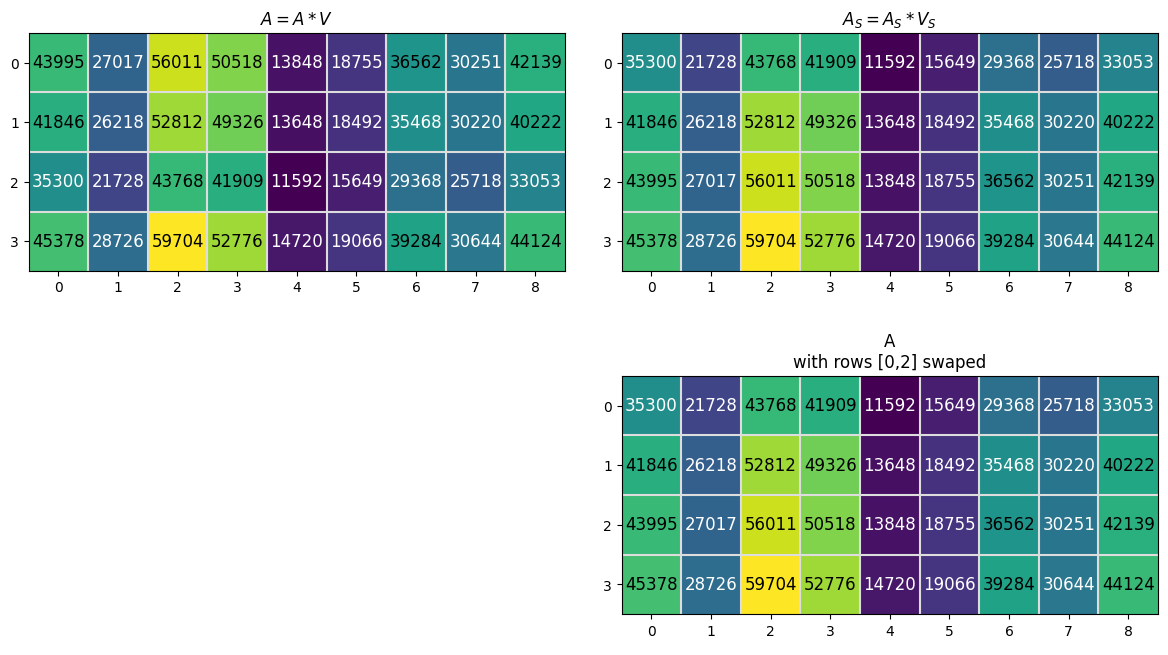

In [35]:
A=A@V
swapA=swapA @swapV
modA=copy.deepcopy(A)
modA[[0,2]]=modA[[2,0]] #swap rpws

fig, axs=plt.subplots(nrows=2, ncols=2, figsize=(12,7))
fig.tight_layout(pad=1.0)
plt.subplot(2,2,1)
mat_plot(A, r'$A=A*V$')
plt.subplot(2,2,2)
mat_plot(swapA, r'$A_S=A_S*V_S$')
plt.subplot(2,2,4)
mat_plot(modA, 'A\nwith rows [0,2] swaped')
axs[1,0]

# Position Embeddings in Literature

In addition to the theoretically justification for positional embeddings, models that utilize position embeddings perform with higher accuracy than models without. However, there isn't clear evidence supporting one type pf position embedding over another.

In Attention is All You Need, they use a fixed **sinusoidal positional embedding**. In An Image is Worth 16x16 $Words^2$, they apply positional embeddings to images. They run ablation studies on four different position embeddings in both fixed and learnable settings. This study encompasses no position embedding, a 1D, 2D and a relative position embedding. **They find that models with a position embedding significantly outperform models without a position embedding**. However, there is a little difference between their different types of positional embeddings or between the fixed and learnable embeddings.

The formulae for the **sinusoidal position embedding**:

$$\theta_{ij}=\frac{i}{10000^{2j^{d-1}}}$$

$$PE_{(i,2j)}=\sin(\theta_{ij})$$

$$PE_{(i, 2j+1)}=\cos(\theta_{ij})$$

where $PE$ is the position embedding matrix, $i$ is along the number of tokens, $j$ is along the length of the tokens, and $d$ is the token length.

In [ ]:
def get_sinusoid_encoding(num_tokens, token_len):
    """
    Args:
        num_tokens (int): number of tokens
        token_len (int): length of a token
        
    Returns:
        (torch.FloatTensor) sinusoidal position encoding table
    """
    
    def get_position_angle_vec(i):
        return [i/np.power(10000, 2*(j//2)/token_len) for j in range(token_len)]
    
    sinusoid_table=np.array([get_position_angle_vec(i) for i in range(num_tokens)])
    sinusoid_table[:,0::2]=np.sin(sinusoid_table[:,0::2])
    